In [158]:
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import pandas as pd
from math import sin, cos, atan, radians, degrees

In [159]:
# The pacejka magic formula
def pacejkaMF(slip, B, C, D, E):
    '''
    slip = slip ratio (from -100 - 100), or angle (-90 to 90)
    B = define the width of the peak + how sharp it is
    C = define the height of the peak
    D = vertical scale of the shape
    E = how sharp it drops after peak
    '''
    Bx = B * slip
    return D * sin( C * atan( Bx - E * ( Bx - atan(Bx) ) ) )

# make sure it's correct
slip = 10.0 # 10% slip
B = 0.714
C = 1.325
D = 1.0
E = -0.2
p = pacejkaMF(slip, B, C, D, E)
print(f"Pacejka of slip={slip}, B({B}), C({C}), D({D}), E({E}) = {p:.2f}")

Pacejka of slip=10.0, B(0.714), C(1.325), D(1.0), E(-0.2) = 0.94


In [160]:
# let's graph it
pacejkaFV = np.vectorize(pacejkaMF)
slip_range = np.linspace(-100.0, 100.0, num=500)
W = 4500 # 4500 N

# B = 0.914
# C = 1.325
# D = 1.0
# E = -0.2

Flong = pacejkaFV(slip_range, B, C, W, E)
Flong_50 = pacejkaFV(slip_range, B, C, W*0.5, E)
Flong_25 = pacejkaFV(slip_range, B, C, W*0.25, E)
max_Flong = np.max(Flong)

result = np.where(Flong == max_Flong)
optimal_slip = slip_range[result[0]]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
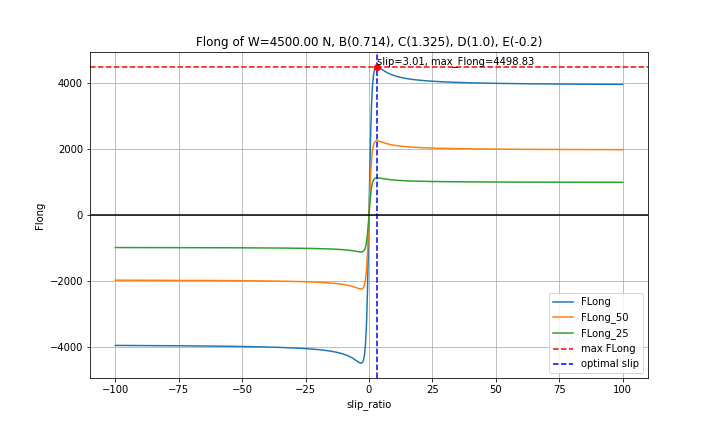

In [171]:
fig = plt.figure('Pacejka Tire Calculator', figsize=(10, 6))

# plot the function curve
plt.plot(slip_range, Flong, label='FLong')
plt.plot(slip_range, Flong_50, label='FLong_50')
plt.plot(slip_range, Flong_25, label='FLong_25')
# plot the axis horizontal line for max_Flong
plt.axhline(max_Flong, color='r', linestyle='dashed', label='max FLong')
# plot the vertical line for optimal slip
plt.axvline(optimal_slip, color='b', linestyle='dashed', label='optimal slip')

# draw marker at maxima
plt.plot(optimal_slip, max_Flong, 'ro')
plt.text(optimal_slip, max_Flong + 64, "slip=%.2f, max_Flong=%.2f" % (optimal_slip, max_Flong) )

plt.title(f"Flong of W={W:.2f} N, B({B}), C({C}), D({D}), E({E})")
plt.xlabel('slip_ratio')
plt.ylabel('Flong')

# zero axis
plt.axhline(0, color='k')
# plt.axvline(0, color='k')

plt.grid()

plt.legend(loc='lower right')

plt.show()